# Elastic full-waveform inversion simple example

@Author: Ettore Biondi - ebiondi@caltech.edu

In this notebook, we run the elastic FWI script to retrieve the subsurface elastic model from recorded seismograms recorded by a linear array of source and receivers, which simulates a horizontal borehole acquisition. The FWI cost function is written as follows,
\begin{eqnarray}
\phi(\mathbf{m}) = \frac{1}{2}\|\mathbf{f}(\mathbf{m}) - \mathbf{d}_{obs} \|_2^2,
\end{eqnarray}
where $\mathbf{f}$ is the non-linear elastic wave-equation operator, $\mathbf{m}$ is the unknown elastic model, and $\mathbf{d}_{obs}$ represents the observed seismograms. We will be using only the horizontal particle velocity component of the data.

## Import modules

In [1]:
# Importing necessary modules
import os
import genericIO
import numpy as np
# Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)

## Source signature

In [42]:
!waveletFloatMain.py timeDelay=1 f1=1.0 f2=4.0 f3=8.0 f4=15.0 type=ali par=EFWI_test.p wavelet=results/tmpwavelet.H

In [43]:
# Reading the wavelet
wavelet = genericIO.defaultIO.getVector("results/tmpwavelet.H")
waveletNd = wavelet.getNdArray()
waveletHyper = wavelet.getHyper()
timeAxis = waveletHyper.getAxis(1)
nt = timeAxis.n
ot = timeAxis.o
dt = timeAxis.d

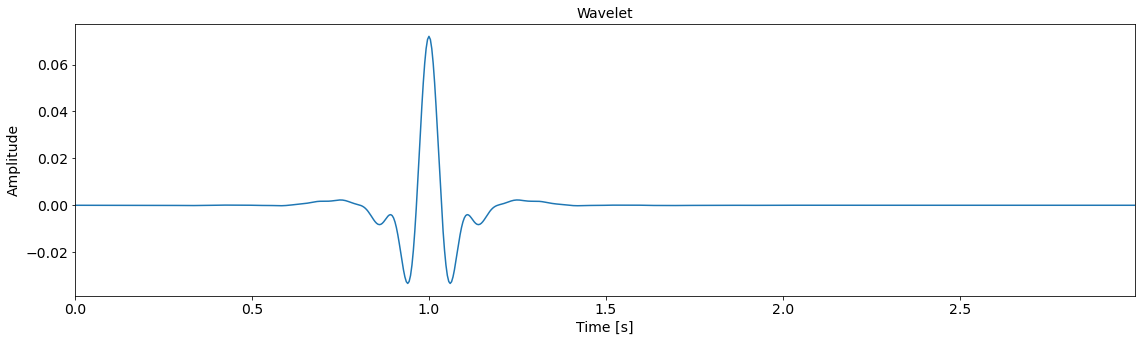

In [44]:
fig,ax=plt.subplots(figsize=(19,5))
time_range = np.linspace(ot,ot+(nt-1)*dt,nt)
plt.plot(np.linspace(ot,ot+(nt-1)*dt,nt), waveletNd)
plt.title('Wavelet'), plt.xlabel("Time [s]"), plt.ylabel("Amplitude")
ax.autoscale(enable=True, axis='x', tight=True)
plt.show()

We are going to inject a force along the z diretion.

In [45]:
compAxis = genericIO.Hypercube.axis(n=5)
ElaSourceHyper = genericIO.Hypercube.hypercube(axes=[timeAxis,compAxis])
ElaSource = genericIO.SepVector.getSepVector(ElaSourceHyper)
# Setting the correct component of the source to the desired signature
scale=1e5 
ElaSource.zero()
ElaSourceNd = ElaSource.getNdArray()
ElaSourceNd[1,:] = waveletNd*scale
ElaSource.writeVec("ElaWaveletFWI.H")

## Generate observed data

The sources and receivers are placed at 500 m below the surface along the x axis.

In [46]:
# Reading Marmousi model as a vector
trueLayer = genericIO.defaultIO.getVector("true_layers.H")
trueLayerNd = trueLayer.getNdArray()
trueLayerHyper = trueLayer.getHyper()
# Getting axes' information
oz = trueLayerHyper.getAxis(1).o
dz = trueLayerHyper.getAxis(1).d
nz = trueLayerHyper.getAxis(1).n
ox = trueLayerHyper.getAxis(2).o
dx = trueLayerHyper.getAxis(2).d
nx = trueLayerHyper.getAxis(2).n
trueVp = trueLayerNd[0,:,:]
trueVs = trueLayerNd[1,:,:]
trueRho = trueLayerNd[2,:,:]

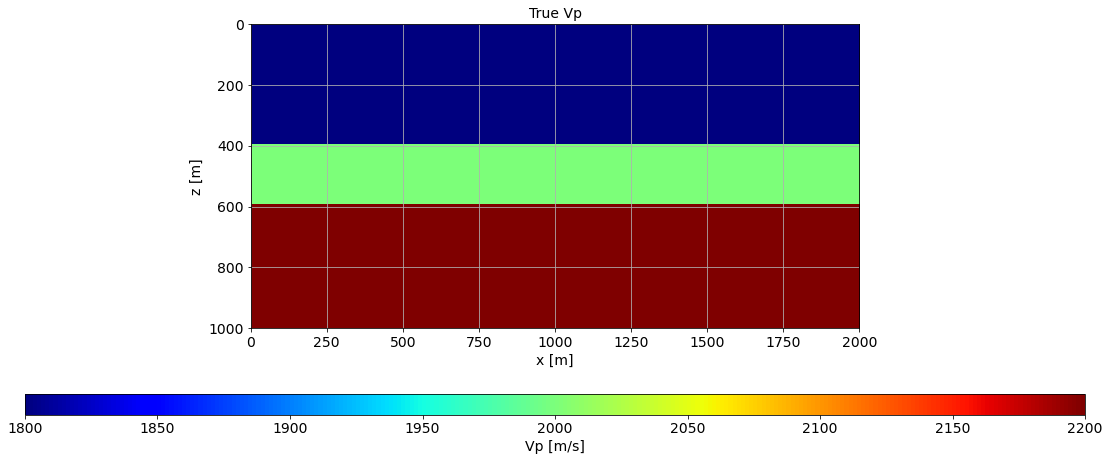

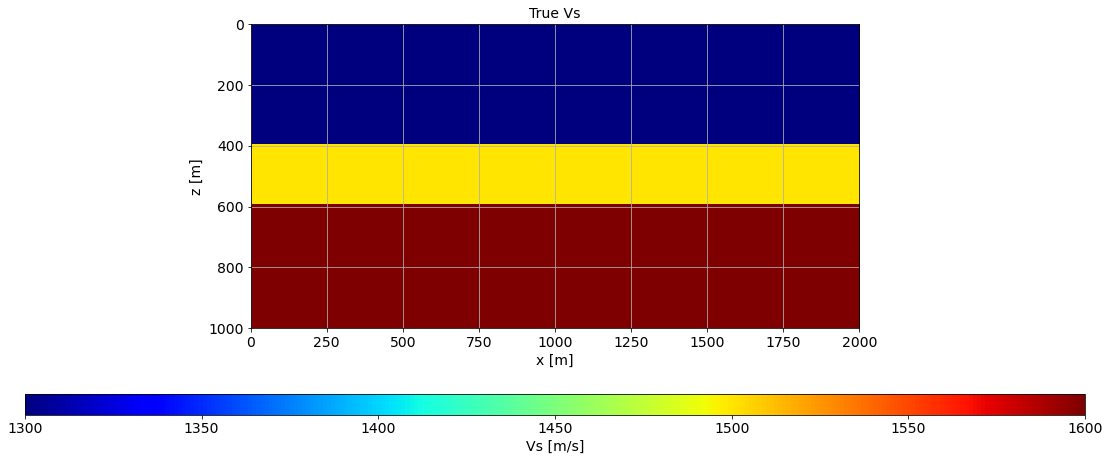

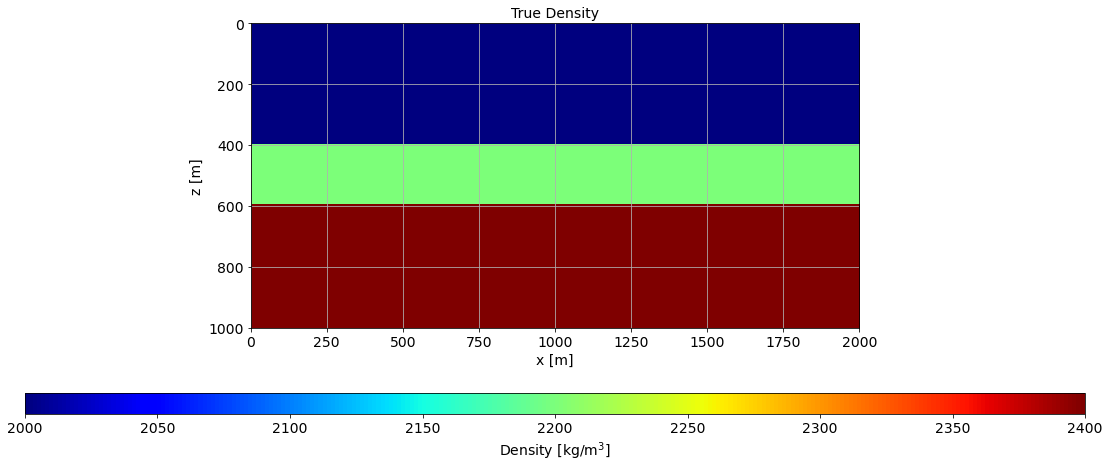

In [60]:
plt.figure(figsize=(19,8))
plt.imshow(trueVp.T,cmap='jet', vmin=trueVp.min(), vmax=trueVp.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("True Vp"), plt.xlabel("x [m]"), plt.ylabel("z [m]")
plt.colorbar(orientation="horizontal", label="Vp [m/s]", aspect=50)
plt.grid()

plt.figure(figsize=(19,8))
plt.imshow(trueVs.T,cmap='jet', vmin=trueVs.min(), vmax=trueVs.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("True Vs"), plt.xlabel("x [m]"), plt.ylabel("z [m]")
plt.colorbar(orientation="horizontal", label="Vs [m/s]", aspect=50)
plt.grid()

plt.figure(figsize=(19,8))
plt.imshow(trueRho.T,cmap='jet', vmin=trueRho.min(), vmax=trueRho.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("True Density"), plt.xlabel("x [m]"), plt.ylabel("z [m]")
plt.colorbar(orientation="horizontal", label="Density [kg/m$^3$]", aspect=50)
plt.grid()
plt.show()

In [48]:
# Pad true velocity model
!padElasticFileGpuMain zPad=100 xPad=100 model=true_layers.H data=true_layers.pad.H

 
------------------------ Model padding program --------------------
Chosen surface condition parameter: (0) no free surface condition
Original nz = 101 [samples]
Original nx = 201 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 103 [samples]
xPadMinus = 100 [samples]
xPadPlus = 115 [samples]
 
blockSize = 16 [samples]
FAT = 4 [samples]
 
New nz = 312 [samples including padding and FAT]
New nx = 424 [samples including padding and FAT]
-------------------------------------------------------------------
 


In [49]:
# Running non-linear operator to elastic data
!nonlinearPythonElasticFloatMain.py elasticParam=true_layers.pad.H model=ElaWaveletFWI.H par=EFWI_test.p data=results/nonlinear_dataFWI.H info=0

-------------------------------------------------------------------
------------------ Running Python nonlinear forward ---------------
-------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------



In [50]:
!dataCompMain.py comp=vx input=results/nonlinear_dataFWI.H output=results/nonlinear_dataFWI_Vx.H

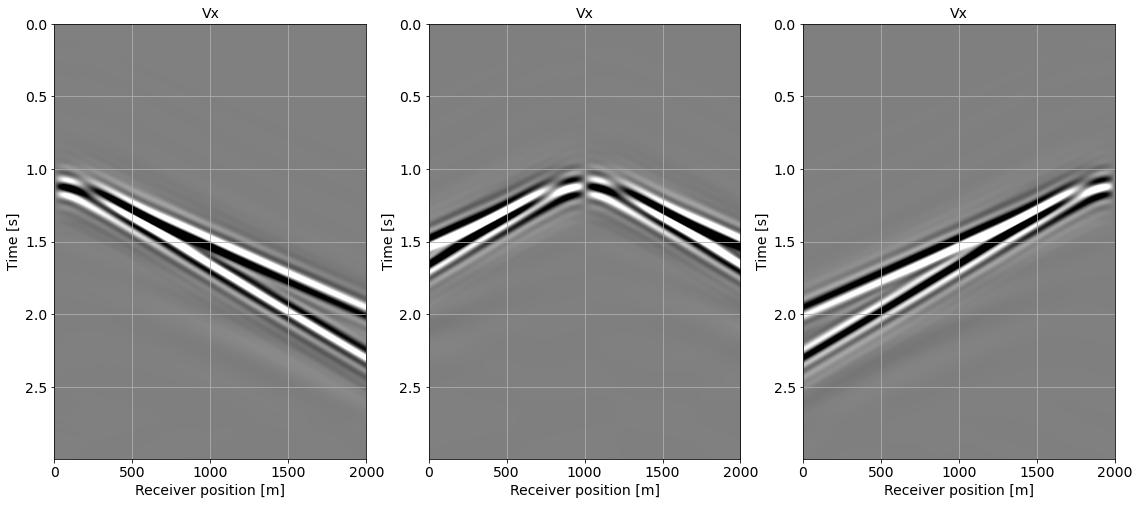

In [59]:
# Plotting the data
Vx = genericIO.defaultIO.getVector("results/nonlinear_dataFWI_Vx.H").getNdArray()
clipVal = np.percentile(np.absolute(Vx),97.0)

plt.figure(figsize=(19,8))

plt.subplot(131), plt.title("Vx")
plt.imshow(Vx[0,:,:,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [m]"), plt.ylabel("Time [s]")
plt.grid()

plt.subplot(132), plt.title("Vx")
plt.imshow(Vx[10,:,:,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [m]"), plt.ylabel("Time [s]")
plt.grid()

plt.subplot(133), plt.title("Vx")
plt.imshow(Vx[-1,:,:,:].T,aspect='auto',extent=(ox, ox+(nx-1)*dx, ot+(nt-1)*dt, ot),
           interpolation="spline16",vmin=-clipVal,vmax=clipVal)
plt.xlabel("Receiver position [m]"), plt.ylabel("Time [s]")
plt.grid()

plt.show()

## Initial guess

The starting guess was created by smoothing the true model along the z direction.

In [53]:
# Reading Marmousi model as a vector
initLayer = genericIO.defaultIO.getVector("smooth_layers.H")
initLayerNd = initLayer.getNdArray()
initVp = initLayerNd[0,:,:]
initVs = initLayerNd[1,:,:]
initRho = initLayerNd[2,:,:]

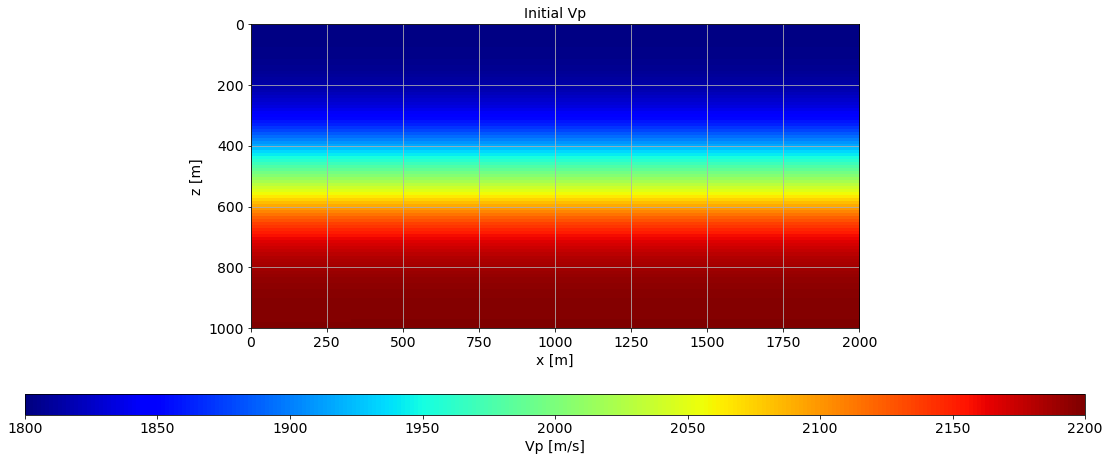

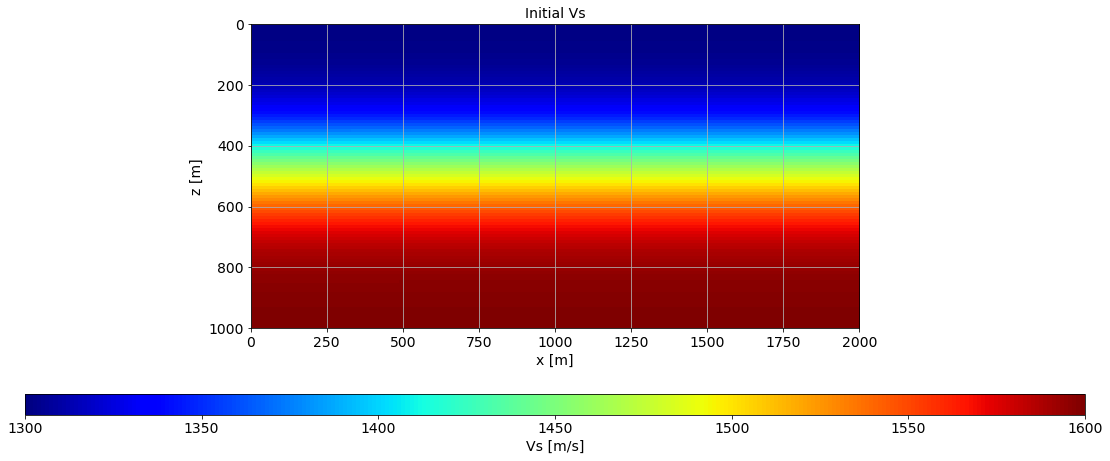

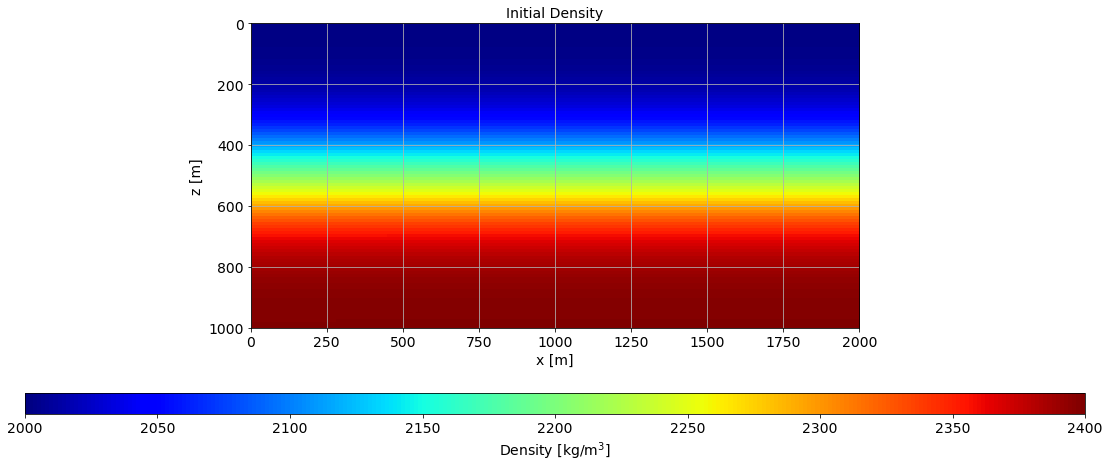

In [58]:
plt.figure(figsize=(19,8))
plt.imshow(initVp.T,cmap='jet', vmin=trueVp.min(), vmax=trueVp.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Initial Vp"), plt.xlabel("x [m]"), plt.ylabel("z [m]")
plt.colorbar(orientation="horizontal", label="Vp [m/s]", aspect=50)
plt.grid()

plt.figure(figsize=(19,8))
plt.imshow(initVs.T,cmap='jet', vmin=trueVs.min(), vmax=trueVs.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Initial Vs"), plt.xlabel("x [m]"), plt.ylabel("z [m]")
plt.colorbar(orientation="horizontal", label="Vs [m/s]", aspect=50)
plt.grid()

plt.figure(figsize=(19,8))
plt.imshow(initRho.T,cmap='jet', vmin=trueRho.min(), vmax=trueRho.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Initial Density"), plt.xlabel("x [m]"), plt.ylabel("z [m]")
plt.colorbar(orientation="horizontal", label="Density [kg/m$^3$]", aspect=50)
plt.grid()
plt.show()

In [55]:
# Pad true velocity model
!padElasticFileGpuMain zPad=100 xPad=100 model=smooth_layers.H data=smooth_layers.pad.H

 
------------------------ Model padding program --------------------
Chosen surface condition parameter: (0) no free surface condition
Original nz = 101 [samples]
Original nx = 201 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 103 [samples]
xPadMinus = 100 [samples]
xPadPlus = 115 [samples]
 
blockSize = 16 [samples]
FAT = 4 [samples]
 
New nz = 312 [samples including padding and FAT]
New nx = 424 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Elastic FWI process

In [57]:
!efwiMain.py sources=ElaWaveletFWI.H elasticParam=smooth_layers.pad.H par=EFWI_test.p data=results/nonlinear_dataFWI_Vx.H nIter=200 folder=efwi-test solver=lbfgs saveObj=1 saveRes=0 saveGrad=0 saveModel=1 comp=vx info=0

----------------------------------------------------------------------
------------------------ Elastic FWI logfile -------------------------
----------------------------------------------------------------------

-------------------------------------------------------------------
--------------------------- All done ------------------------------
-------------------------------------------------------------------



Let's analyze the results! First the objective function.

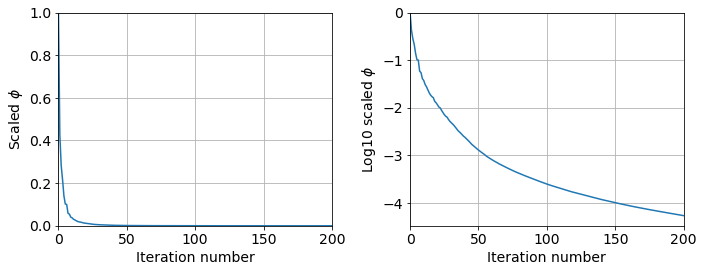

In [61]:
# Reading and plotting the FWI objective function
objFWI = genericIO.defaultIO.getVector("efwi-test/efwi-test_obj.H")
objFWINd = objFWI.getNdArray()

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(objFWINd/objFWINd[0])
# plt.title("LCG convergence")
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([0,1])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.subplot(122)
plt.plot(np.log10(objFWINd/objFWINd[0]))
plt.xlabel("Iteration number",fontsize=14)
plt.ylabel("Log10 scaled $\phi$",fontsize=14)
ax = plt.gca() 
plt.ylim([None,0])
plt.grid()
ax.autoscale(enable=True, axis='x', tight=True)
plt.tight_layout()

From these plots we can say that we match the observed data almost up to the numerical precision of the operator. Let's have a look at the inverted model parameters.

In [79]:
# Reading and plotting inverted model as a vector
elaFWImod = genericIO.defaultIO.getVector("efwi-test/efwi-test_inv_mod.H")
# Removing absorbing boundaries
elaFWImodNd = elaFWImod.getNdArray()[:,101:302,103:204]
elaFWImodVp = elaFWImodNd[0,:,:]
elaFWImodVs = elaFWImodNd[1,:,:]
elaFWImodRho = elaFWImodNd[2,:,:]

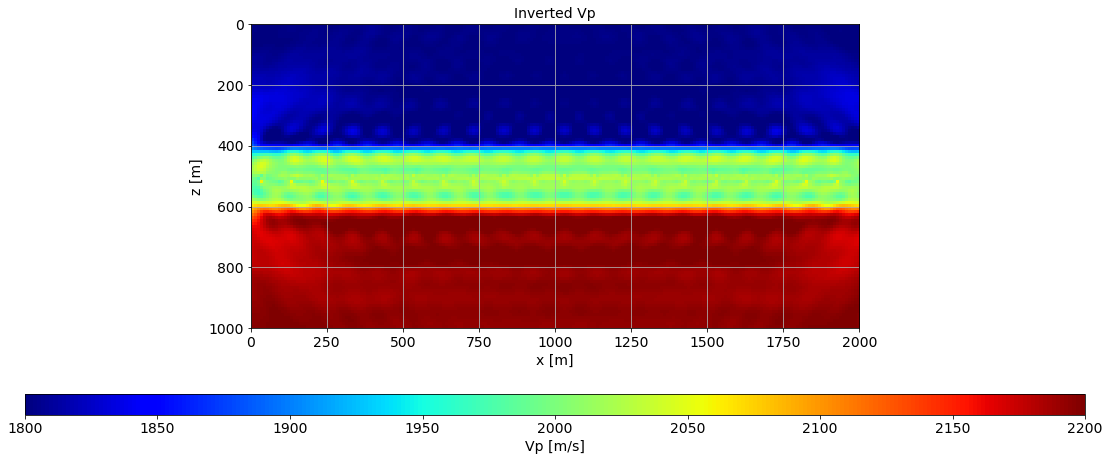

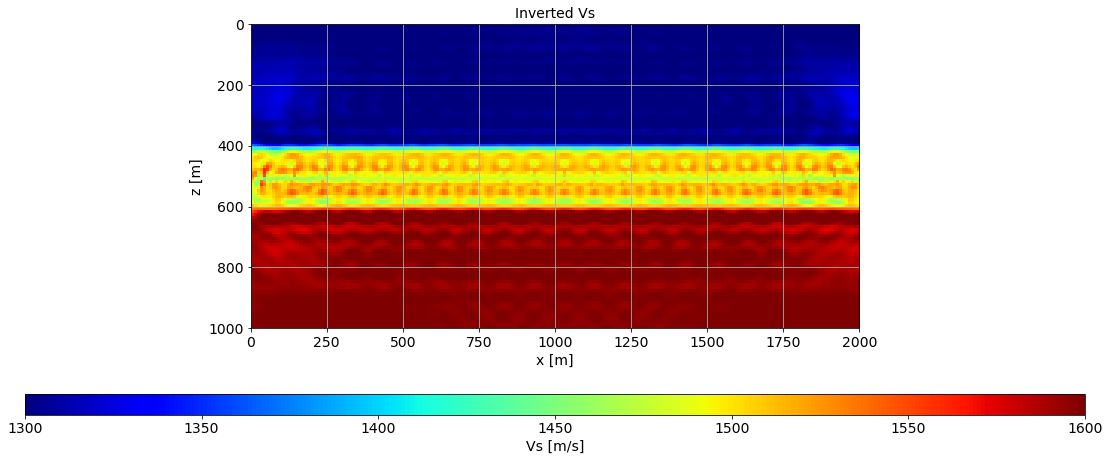

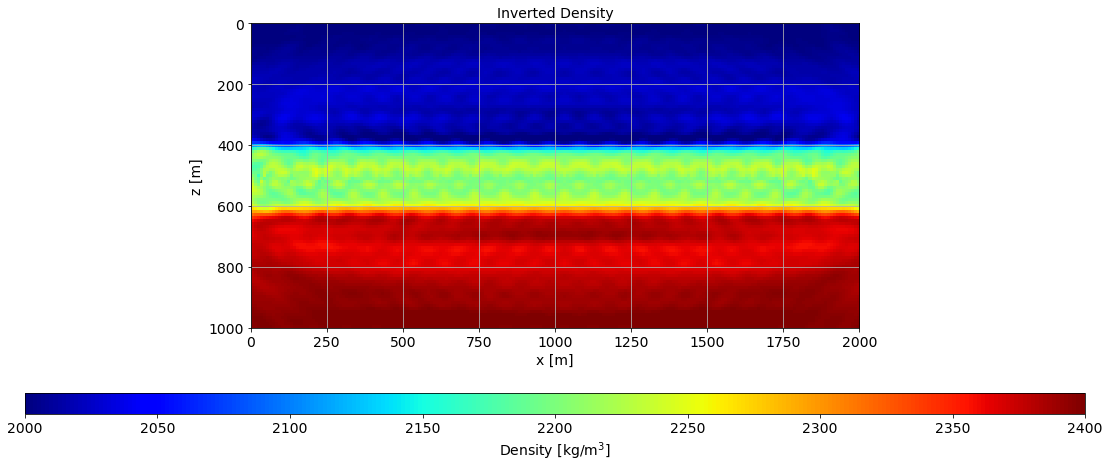

In [80]:
plt.figure(figsize=(19,8))
plt.imshow(elaFWImodVp.T,cmap='jet', vmin=trueVp.min(), vmax=trueVp.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Inverted Vp"), plt.xlabel("x [m]"), plt.ylabel("z [m]")
plt.colorbar(orientation="horizontal", label="Vp [m/s]", aspect=50)
plt.grid()

plt.figure(figsize=(19,8))
plt.imshow(elaFWImodVs.T,cmap='jet', vmin=trueVs.min(), vmax=trueVs.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Inverted Vs"), plt.xlabel("x [m]"), plt.ylabel("z [m]")
plt.colorbar(orientation="horizontal", label="Vs [m/s]", aspect=50)
plt.grid()

plt.figure(figsize=(19,8))
plt.imshow(elaFWImodRho.T,cmap='jet', vmin=trueRho.min(), vmax=trueRho.max(), 
           extent=(ox, (ox+(nx-1)*dx), (oz+(nz-1)*dz), oz),aspect="equal")
plt.title("Inverted Density"), plt.xlabel("x [m]"), plt.ylabel("z [m]")
plt.colorbar(orientation="horizontal", label="Density [kg/m$^3$]", aspect=50)
plt.grid()
plt.show()

The inversion process retrieves fairly accurate parameters considering the simple objective function employed in the inversion. We could have achieve even better results by employing model masking and regularization techniques.